# Grammy EDA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import json

In [2]:
def create_connection():
    try:
        with open('../etl_dag/db_config.json') as file:
            config = json.load(file)
        cnx = psycopg2.connect(
            host='localhost',
            user=config["user"],
            password=config["password"],
            database=config["database"]
        )
        print('Conexión exitosa!!')
    except psycopg2.Error as e:
        cnx = None
        print('No se puede conectar:', e)
    return cnx

def run_query(sql):
    cnx = create_connection()
    cur = cnx.cursor()
    cur.execute(sql)
    rows = cur.fetchall()
    columns = [col[0] for col in cur.description]
    df = pd.DataFrame(rows)
    df.rename(columns=dict(zip(range(len(columns)), columns)), inplace=True)  
    cnx.close()
    return df

**Cargar los datos**

In [3]:
sql='''SELECT *
FROM grammy
'''
grammy_df = run_query(sql)

Conexión exitosa!!


**Mostrar las primeras filas del DataFrame**

In [4]:
grammy_df.head()

,grammy_id,year,title,published_at,updated_at,category,nominee,artist,workers,img,winner
0,1,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,Bad Guy,Billie Eilish,"Finneas O'Connell, producer; Rob Kinelski & Fi...",https://www.grammy.com/sites/com/files/styles/...,True
1,2,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,"Hey, Ma",Bon Iver,"BJ Burton, Brad Cook, Chris Messina & Justin V...",https://www.grammy.com/sites/com/files/styles/...,True
2,3,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,7 rings,Ariana Grande,"Charles Anderson, Tommy Brown, Michael Foster ...",https://www.grammy.com/sites/com/files/styles/...,True
3,4,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,Hard Place,H.E.R.,"Rodney “Darkchild” Jerkins, producer; Joseph H...",https://www.grammy.com/sites/com/files/styles/...,True
4,5,2019,62nd Annual GRAMMY Awards (2019),2020-05-19 05:10:28,2020-05-19 05:10:28,Record Of The Year,Talk,Khalid,"Disclosure & Denis Kosiak, producers; Ingmar C...",https://www.grammy.com/sites/com/files/styles/...,True


**Verificar las dimensiones del DataFrame**

In [5]:
grammy_df.shape

(4810, 11)

El tamaño de nuestro conjunto de datos es de 4810 premios con 11 columnas.

**Exploración de Tipos de Datos**

In [6]:
grammy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4810 entries, 0 to 4809
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   grammy_id     4810 non-null   int64         
 1   year          4810 non-null   int64         
 2   title         4810 non-null   object        
 3   published_at  4810 non-null   datetime64[ns]
 4   updated_at    4810 non-null   datetime64[ns]
 5   category      4810 non-null   object        
 6   nominee       4810 non-null   object        
 7   artist        4810 non-null   object        
 8   workers       4810 non-null   object        
 9   img           4810 non-null   object        
 10  winner        4810 non-null   bool          
dtypes: bool(1), datetime64[ns](2), int64(2), object(6)
memory usage: 380.6+ KB


**Investigación de Valores Nulos**

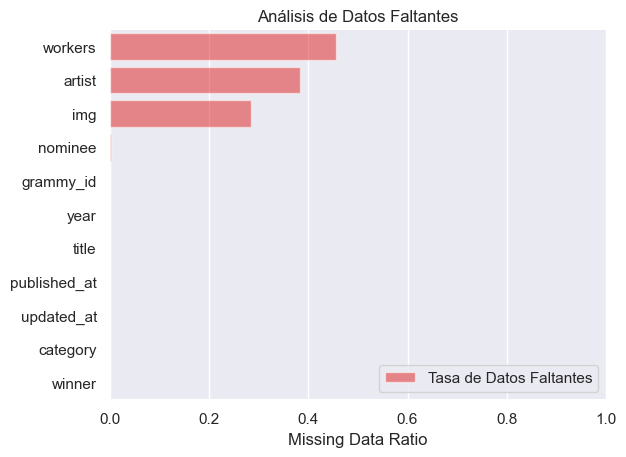

In [7]:
missing_ratios = grammy_df.apply(lambda x: x.astype(str).str.lower() == 'nan').mean()
missing_ratios = missing_ratios.sort_values(ascending=False)

sns.set_theme()

sns.set_color_codes("pastel")
sns.barplot(x=missing_ratios, y=missing_ratios.index,
            label="Tasa de Datos Faltantes", color="red", alpha=0.5)

plt.legend(ncol=1, loc="lower right", frameon=True)
plt.xlim(0, 1)
plt.xlabel("Missing Data Ratio")
plt.ylabel("")
plt.title("Análisis de Datos Faltantes")
sns.despine(left=True, bottom=True)
plt.show()

Las columnas workers, artist e img muestran proporciones significativas de valores iguales a 'NaN', lo que sugiere la presencia de datos faltantes en estas columnas. Es probable que necesitemos abordar estos datos faltantes antes de realizar análisis 

**Número de Duplicados en el DataFrame**

In [8]:
grammy_df.duplicated().sum()

0

**winner**

In [15]:
grammy_df['winner'].unique()

array([ True])

 Esto implica que todos los registros son ganadores de los premios Grammy.

In [17]:
grammy_df[['year','category','nominee','winner']].head(2)

,year,category,nominee,winner
0,2019,Record Of The Year,Bad Guy,True
1,2019,Record Of The Year,"Hey, Ma",True


Se pueden observar registros en los que varios nominados en una misma categoría han sido etiquetados como ganadores de los premios Grammy. En lugar de considerarlos ganadores, es más apropiado considerarlos como nominados a los premios Grammy. 

**category**

In [20]:
grammy_df['category'].nunique()

638

Se han identificado un total de 638 categorías en los premios Grammy, lo que representa un número significativamente elevado para intentar una clasificación detallada.

In [21]:
grammy_df['category'].value_counts()

category
Song Of The Year                                                   70
Record Of The Year                                                 69
Album Of The Year                                                  66
Best Opera Recording                                               64
Best Album Notes                                                   63
                                                                   ..
Best Sacred Performance (Musical)                                   1
Best Jazz Performance - Small Group Or Soloist With Small Group     1
Best Jazz Performance - Large Group Or Soloist With Large Group     1
Best Contemporary Vocal Performance By A Group                      1
Best Classical Performance - Operatic Or Choral                     1
Name: count, Length: 638, dtype: int64

**artist**

In [44]:
grammy_df[grammy_df['artist'].str.contains('NaN', na=False)][['artist', 'nominee', 'category']].sample(4)

,artist,nominee,category
690,NaN,Dutilleux: Sur Le Même Accord; Les Citations; ...,Best Surround Sound Album
347,NaN,The Radio Recordings 1939–1945,Best Boxed Or Special Limited Edition Package
2285,NaN,Steven Epstein,"Producer Of The Year, Classical"
2381,NaN,NaN,"Remixer Of The Year, Non-Classical"


Se puede observar que la presencia de 'NAN' en la columna pueda estar relacionada con la categoría del premio.

**nominee**

In [54]:
grammy_df[['nominee', 'category']].sample(5)

,nominee,category
776,Uptown Funk (Dave Audé Remix),Best Remixed Recording
2960,Sneakin' Around,Best Country Instrumental Performance
898,The Heist,Best Rap Album
2267,Harry Potter And The Goblet Of Fire,Best Spoken Word Album for Children
363,Finneas,"Producer Of The Year, Non-Classical"


Entre los nominados en los premios Grammy, se incluyen una variedad de categorías que abarcan canciones, artistas, productores y álbumes. 